<a href="https://colab.research.google.com/github/Adrok24/Proyecto-Integrador/blob/branch_1/TVAE_Test_and_visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-datasets==1.2.0

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Dense, LSTM, Bidirectional, TimeDistributed
import tensorflow.keras.backend as K
import pandas as pd

tf.random.set_seed(1234)
pd.options.display.max_colwidth = 100

In [ ]:
## Vamos a bajarnos el dataset de dialogos de peliculas de Cornell University
# folder = '/content/drive/My Drive/My Drive/Colab Notebooks/desafio final/'
folder = '/content/drive/My Drive/Colab Notebooks/desafio final/'

path_to_corpus = os.path.join(folder, 'train_corpus_v3.csv')
path_to_corpus

'/content/drive/My Drive/Colab Notebooks/desafio final/train_corpus_v3.csv'

In [ ]:
data = pd.read_csv(path_to_corpus, index_col=0)

In [ ]:
data.sample(10)

line  ...  Sentimiento
293334                                                               de madrugada se dirigió al embarcadero  ...          NEU
5035    ¡ y al final no ocurrió nada en la cámara  ,  no la intervinieron ni la asaltaron ni la violaron...  ...          NEG
303598                                                 un constructor repitió él y observó cómo se marchaba  ...          NEU
159296                          ¿ le has dicho algo contra el propietario del rancho que pensamos cruzar  ?  ...          NEG
305855                                                               ¡ tú mirabas los telegramas  !   .   .  ...          NEG
157286  ¿ me estás diciendo que aunque se quieran no quieres que se casen porque él no puede montar en b...  ...          NEG
10585                    el chofer se había retirado y esperaba en la puerta  ,  charlando con la enfermera  ...          NEU
263077                                                     ¿ la habías invocado con una danza o algo así  ?  ...          NEU
266008                                    al regresar a casa aquella noche  ,  se sintió como la cenicienta  ...          NEU
18053                                                                     @name lo único que se podía hacer  ...          NEG

[10 rows x 6 columns]

In [ ]:
data.shape

(316618, 6)

In [ ]:
data.iloc[0:5,0]

0             bestiario es el primer libro de relatos que @name cortázar publica con su auténtico nombre
2    sorpresa o incomodidad son  ,  en cada texto  ,  un condimento que se agrega al placer indescrip...
4                                                                 a @name  ,  que gustaba de mis relatos
5    almorzábamos a mediodía  ,  siempre puntuales ya no quedaba nada por hacer fuera de unos pocos p...
6    nos resultaba grato almorzar pensando en la casa profunda y silenciosa y cómo nos bastábamos par...
Name: line, dtype: object

In [ ]:
## tokenizador de subwords
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    data.iloc[:,0].tolist(), target_vocab_size=2**13)

### Preprocesamiento

In [ ]:
# Usamos train_test_split() para filtrar el volumen de lineas que le vamos a pasar al entrenamiento
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['line', 'len', 'book', 'Sentimiento']], data['genre'], test_size=0.20, random_state=42, stratify=data['genre'])
print('X_train: ',X_train.shape, 'X_test: ',X_test.shape, 'y_train: ',y_train.shape, 'y_test: ',y_test.shape)

X_train:  (253294, 4) X_test:  (63324, 4) y_train:  (253294,) y_test:  (63324,)


In [ ]:
data_train = pd.concat([X_train, y_train],axis=1)
data_test = pd.concat([X_test, y_test],axis=1)

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size

In [ ]:
## el tokenizador tiene dos metodos: encode y decode:
print(tokenizer.encode("cantar"))
print(tokenizer.decode(tokenizer.encode("cantar")))

[4969]
cantar


In [ ]:
sample_string = 'todo lo que nos desvela'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenizada {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('Original: {}'.format(original_string))

for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

assert original_string == sample_string

Tokenizada [50, 14, 3, 74, 3740, 778]
Original: todo lo que nos desvela
50 ----> todo 
14 ----> lo 
3 ----> que 
74 ----> nos 
3740 ----> desv
778 ----> ela


In [ ]:
# Funcion para utilizar luego en la reconstrucción
def tokenize_and_filter(inputs):
  tokenized_inputs = []
  
  for sentence1 in inputs:
    # tokenizamos + tokens especiales
    sentence1 = tokenizer.encode(sentence1)
    # filtramos
    if len(sentence1) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
  
  # paddeamos
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs

In [ ]:
# Tokenizamos, filtramos las secuencias menores al largo maximo
# y las paddeamos 
def tokenize_and_filter_df(inputs):
  tokenized_inputs = {}
  count_dict = 0
  for index, line in inputs.iterrows():
    sentence = line['line']
    # tokenizamos + tokens especiales
    sentence = tokenizer.encode(sentence)
    # filtramos
    if len(sentence) <= MAX_LENGTH:
      # tokenized_inputs.append(sentence)
      tokenized_inputs[count_dict] = {"line": sentence, "len": len(sentence), "genre": line['genre'], "sent": line['Sentimiento']}
      count_dict += 1

  data_filtered = pd.DataFrame.from_dict(tokenized_inputs, "index")
  
  return data_filtered

data_tokens = tokenize_and_filter_df(data_train)
data_tokens_test = tokenize_and_filter_df(data_test)

In [ ]:
display(data_tokens.sample(3))
display(data_tokens_test.sample(3))

line  ...  sent
249269                             [7997, 9, 416, 2141, 294, 8033, 60, 9, 3012, 8030, 60, 9, 1135, 199]  ...   NEU
40298                                                [193, 10, 207, 6, 138, 8030, 12, 9, 16, 2738, 979]  ...   NEG
8020    [6, 193, 54, 4684, 14, 3, 1194, 1, 14, 3, 484, 6770, 8030, 12, 131, 1, 14, 3, 169, 283, 5, 917]  ...   NEU

[3 rows x 4 columns]

line  ...  sent
24137  [5081, 46, 4653, 20, 6302, 20, 141, 53, 6437, 20, 6, 2836, 10, 5765, 7965, 4, 1011, 6, 4435, 796...  ...   NEG
51243                               [30, 443, 125, 110, 425, 158, 5, 4, 2918, 1, 280, 4, 4857, 2, 18, 332]  ...   NEG
19829                                            [11, 7632, 46, 237, 24, 318, 29, 2754, 49, 4, 5667, 8030]  ...   NEG

[3 rows x 4 columns]

In [ ]:
# paddeamos
data_lines = tf.keras.preprocessing.sequence.pad_sequences(
    data_tokens.line.tolist(), maxlen=MAX_LENGTH, padding='post')

data_lines_test = tf.keras.preprocessing.sequence.pad_sequences(
    data_tokens_test.line.tolist(), maxlen=MAX_LENGTH, padding='post')


data_tokens.line = data_lines.tolist()
data_tokens_test.line = data_lines_test.tolist()

display(data_tokens.sample(3))
display(data_tokens_test.sample(3))

line  ...  sent
21689   [2657, 2950, 54, 56, 1233, 1727, 253, 8, 7146, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  ...   NEU
161064  [40, 6, 24, 4627, 1984, 1, 6, 24, 625, 1109, 2025, 1004, 1, 6, 24, 945, 4327, 7965, 1013, 4143, ...  ...   NEG
5868    [15, 33, 3297, 102, 7670, 7, 33, 4007, 6919, 8048, 1, 95, 729, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  ...   POS

[3 rows x 4 columns]

line  ...  sent
10636  [2937, 3712, 440, 5, 21, 1053, 2833, 280, 8, 1890, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  ...   NEG
13551  [6, 425, 6960, 7965, 109, 259, 2344, 2, 158, 904, 75, 2183, 2318, 7965, 11, 443, 13, 499, 4505, ...  ...   NEU
30216  [5765, 7965, 134, 1400, 1, 3, 141, 8, 1081, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  ...   NEU

[3 rows x 4 columns]

In [ ]:
print('Tamaño vocabulario: {}'.format(VOCAB_SIZE))
print('frases: {}'.format(len(data_lines)))

Tamaño vocabulario: 8189
frases: 249849


In [ ]:
# Tomamos la mayor cantidad de frases que sea multiplo de [BATCH_SIZE] para no generar problemas en el entrenamiento
FINAL_LINES = int(len(data_lines) / BATCH_SIZE) * BATCH_SIZE
FINAL_LINES

249792

In [ ]:
# Adapto para que de un multiplo del batch size (64)
data_lines = data_lines[0:FINAL_LINES]
len(data_lines)

249792

In [ ]:
# saco el token de start de los outputs
dataset = tf.data.Dataset.from_tensor_slices((data_lines,data_lines))

dataset = dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
#dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Elementos básicos

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculamos attention weights """

  ## hacemos el producto de query por la transpuesta de key
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  ## escalamos por la raiz cuadrado del # dims
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  ## agregamos la mascara
  if mask is not None:
    logits += (mask * -1e9)

  ## aplicamos la softmax
  attention_weights = tf.nn.softmax(logits, axis=-1)

  ## y multiplicamos por value 
  output = tf.matmul(attention_weights, value)

  return output

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  ''' Vamos a armar la capa para multihead attention '''

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)

    ## que es este super?
    ## super() te permite acceeder a los metodos de la super clase de la cual
    ## la subclase está heredando. En este caso, estas herendando de Layers.
        
    ## definimos algunos parametros: cuantas cabezas va a tener self attention 
    ## y la dimensionalidad del embedding
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    ## cuantas dimensiones va a tener cada cabeza:
    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    ## vamos a armar la division en cabezas. 
    ## se va a entender mejor en el siguiente bloque de codigo
    ## por ahora es solamente la forma en la que 
    ## reacomodamos los datos para armar las cabezas
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])


  def get_config(self):
          config = super().get_config().copy()
          config.update({
              'num_heads': self.num_heads,
              'd_model': self.d_model,
              'depth': self.depth,
              'query_dense': self.query_dense,
              'key_dense': self.key_dense,
              'value_dense': self.value_dense,
              'dense': self.dense             
          })
          return config

  def call(self, inputs):
    ''' Este call es el metodo que  va a llamar keras para usar la capa'''

    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # print(self.name, mask)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    # acomodamos las dimensiones
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenamos las cabezas
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
## creamos una mascara para el padding (asi nos nos molesta)
## con esto lo que hacemos es despues pasarselo a la capa 
## anterior y eliminamos los paddings

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)

  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
## vamos a crear la otra mascara:
## ahora queremos la mascara para no ver el futuro
## vamos a incorporarle tambien la mascara para el padding

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

  ## aca la mascara para el padding
  padding_mask = create_padding_mask(x)

  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
  ''' Armamos los encodings de posición '''

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  ## comparar con formula de la teorica
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

   
  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # seno a los indices pares
    sines = tf.math.sin(angle_rads[:, 0::2])
    # coseno a los impares
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, :]
    return tf.cast(pos_encoding, tf.float32)

  def get_config(self):

          config = super().get_config().copy()
          config.update({
              'pos_encoding': self.pos_encoding
          })
          return config

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Encoder

In [ ]:
class Sampling(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

In [ ]:
## ya tenemos todos los ingredientes para armar una capa de encoder
## todavía no es el encoder entero!

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
## ahora si: el encoder
## vamos a definir una funcion que nos devuelva un modelo que tenga
## num_layers bloques de encoder:

def encoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout, latent_space, name="encoder"):
  
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  print('enc_inputs',inputs)

  padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  ## partimos de los embeddings
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  ## y les sumamos el positional encoding
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  ## y usamos tantos bloques como querramos
  for i in range(num_layers):
    outputs = encoder_layer(
                            units=units,
                            d_model=d_model,
                            num_heads=num_heads,
                            dropout=dropout,
                            name="encoder_layer_{}".format(i),
                        )([outputs, padding_mask])

  outputs  = tf.keras.layers.Reshape([MAX_LENGTH * d_model])(outputs)
  # Generamos la media
  
  outputs = tf.keras.layers.Dense(MAX_LENGTH * 10)(outputs)

  outputs = tf.keras.layers.Dense(latent_space)(outputs)
  

  mu = Dense(latent_space, name='mu')(outputs) #TODO: revisar la dimensionalidad del espacio latente


  # Generamos el logaritmo de la varianza
  logvar = Dense(latent_space, name='logvar')(outputs)
  # Usamos esos parámetros para samplear el espacio latente
  z = Sampling(name='encoder_output')([mu, logvar])

  #output = Dense(d_model, name='latent space')(outputs)

  return tf.keras.Model(
      inputs=inputs, outputs=[mu, logvar, z], name=name)

### Decoder

In [ ]:
## vamos a usar las mismas partes que ya tenemos para armar el decoder
## primero la decoder layer

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  
  decoder_input = tf.keras.Input(shape=(None, d_model), name="decoder_input_layer")
  
  # look_ahead_mask = tf.keras.Input(
  #     shape=(1, None, None), name="look_ahead_mask")

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': decoder_input,
          'key': decoder_input,
          'value': decoder_input,
          'mask': None #padding_mask
      })

  #Normalization1
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + decoder_input)

  #FeedFoward
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)

  #Normalization2
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

  return tf.keras.Model(
      inputs=[decoder_input],
      outputs=outputs,
      name=name)

In [ ]:
## y ahora usamos la decoder layer para el decoder

def decoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout ,latent_space, name='decoder'):

  decoder_input = tf.keras.Input(shape=(latent_space), name='decoder_input')

  output = tf.keras.layers.Dense(MAX_LENGTH * 10)(decoder_input)

  
  output = Dense(MAX_LENGTH * d_model, name='linear_proyection')(output)

  output = tf.keras.layers.Reshape([MAX_LENGTH, d_model])(output)
 # print('linear_proyection', output.shape)

  ## la mascara para no ver el futuro y para el padding
  ## ojo que la toma de afuera (es un input, no la creamos aca)

  # look_ahead_mask = tf.keras.Input(
  #     shape=(1, None, None), name='look_ahead_mask')
  

  outputs = tf.keras.layers.Dropout(rate=dropout)(output)

  ## vamos a tener num_layers bloques de decoders
  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs])

  outputs = tf.keras.layers.TimeDistributed(Dense(256))(outputs)
  outputs = tf.keras.layers.LSTM(units=256, return_sequences=True, name='LSTM')(outputs)
  outputs = tf.keras.layers.TimeDistributed(Dense(256))(outputs)


  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)

#  print('final', output.shape)

  return tf.keras.Model(
      inputs=[decoder_input],
      outputs=outputs,
      name=name)

### Modelo VAE

In [ ]:
from tensorflow.keras.models import Model
from contextlib import suppress


beta = K.variable(value=0.0)
beta._trainable = False

class VAEModel(Model):
    def __init__(self, encoder, decoder, a, b, vocab_size, num_layers, units, d_model, num_heads, dropout, latent_space, mask=None,  **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          latent_space=latent_space)
        
        self.decoder = decoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          latent_space=latent_space)
        
        self.a = a
        self.b = b

    def loss_function(self, y_true, y_pred):
      print("ytrue:",y_true,"ypred:",y_pred)
      y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH)) #(-1, MAX_LENGTH - 1))
      
      ## calculamos la loss sin reducir
      loss = tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True, reduction='none')(y_true, y_pred)

      ## y reducimos la loss
      return tf.reduce_mean(loss)

    # Definimos el train step para que utilice la función de costo compuesta por el error de reconstrucción y la divergencia KL
    def train_step(self, data):
        data = data[0]

        
        # Iniciamos el cálculo de la loss dentro del contexto que registra las operaciones para poder derivarlas
        with tf.GradientTape() as tape:
            # Usamos el encoder para mapear las oraciones al espacio latente y obtenemos los parámetros de la distribución
            
            
            z_mean, z_log_var, z = self.encoder(data)
            # Reconstruimos la oración a partir de z

            reconstruction = self.decoder(z)

            reconstruction_loss = self.loss_function(data, reconstruction)

            # Escalamos la pérdida con el r_loss_factor
           # reconstruction_loss *= self.r_loss_factor
            # Calculamos la divergencia KL usando la media y la varianza
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_sum(kl_loss, axis = 1)
            kl_loss *= -0.5
            # Combinamos las pérdidas
            factor = self.a * beta + self.b
            total_loss = reconstruction_loss + kl_loss * factor

        # Calculamos los gradientes
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        # Actualizamos los pesos
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # El método train_step debe devolver un diccionario
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "kl_weight": factor,
        }

    def reconstruct(self, q_sample, silent_reconstruct=False, silent_orig=True):
      _,_,result = model.encoder(q_sample.reshape(1,MAX_LENGTH,1))
      #decoded from sample
      print('Reconstr: ',self.decode_sample(result, silent_reconstruct))

      # original  
      print('Original: ',tokenizer.decode([i for i in q_sample if i < tokenizer.vocab_size]))
      if (silent_orig == False):
        print(q_sample)

    def decode_sample(self, z_sampled, silent_reconstruct=False):
      result = self.decoder(z_sampled)
      with suppress(Exception):
        prediction = np.argmax(result, axis=2)

        pred = prediction[0]
        pred_to_decode = [i for i in pred if i < tokenizer.vocab_size]
        if (silent_reconstruct == False):
          print(pred_to_decode)
        return tokenizer.decode(pred_to_decode)


    def reconstruct_sentence(self, sentence, silent_reconstruct=False, silent_orig=True):
      sentence = [sentence]
      sentence = tokenize_and_filter(sentence)
      sentence = sentence.reshape(MAX_LENGTH)
      return self.reconstruct(sentence, silent_reconstruct, silent_orig)

    def call(self,inputs):
        mu, logvar, z = self.encoder(inputs)
        print("checkpoint_call")

        return self.decoder(z)

In [ ]:
# Hyper-parameters
NUM_LAYERS = 6
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2
LATENT_SPACE = 32
A = 0.0000001
B = 0.00001

# Instanciamos el modelo
model = VAEModel(encoder, decoder, 
    a=A,
    b=B,
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    latent_space=LATENT_SPACE)

enc_inputs KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")


In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/desafio final/weights_corpus_v4.HDF5')

## Testeamos

In [ ]:
def generate_from_normal(n_sentences=3):
  errores = 0
  for i in range(n_sentences):
    z_sampled = tf.random.normal(shape=(1,LATENT_SPACE))
    prediction = model.decode_sample(z_sampled,silent_reconstruct=True)
    print(i, ' gen_norm:', prediction)

In [ ]:
generate_from_normal()

0  gen_norm: raro ahoracuesta hacerte cuesta deseo a tu inconafropolame necesita añadió nerviosa con cara que  ,  entonces le sola severa de los culcueno
1  gen_norm: None
2  gen_norm: éstellos se quierespasa quepero @horde cabeza de los libros de glak american para ellaa tieneella


In [ ]:
q_sample = data_lines[5]
model.reconstruct(q_sample)

[7, 8, 1151, 58, 1229, 23, 13, 5835, 2, 2611, 1521, 423, 254, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Reconstr:  en el fondo mi propio es un sentimiento de reconciliación
Original:  en el fondo mi alegría es un sentimiento de reconciliación


In [ ]:
model.reconstruct_sentence("el devenir de los momentos", silent_reconstruct=True)
model.reconstruct_sentence("las historias que nos contaron", silent_reconstruct=True)
model.reconstruct_sentence("tu mirada milagrosa me salvó de su odio", silent_reconstruct=True)
model.reconstruct_sentence("cayó como un rayo de luz que cegó al mundo", silent_reconstruct=True) 
model.reconstruct_sentence("un hombre observaba desde el monte", silent_reconstruct=True) 

Reconstr:  el bebé miento de los momentos
Original:  el devenir de los momentos
Reconstr:  las historias que nos contaron
Original:  las historias que nos contaron
Reconstr:  tu mirada habición le salvó de su odio
Original:  tu mirada milagrosa me salvó de su odio
Reconstr:  cayó como un rayo de luz que songó al mundo
Original:  cayó como un rayo de luz que cegó al mundo
Reconstr:  un hombre observaba desde el monte
Original:  un hombre observaba desde el monte


In [ ]:
# Genera una funcion que se mueve por el espacio latente desde Oracion A hasta Oracion B
def linear_interpolate(sample1, sample2, cant_sentences = 5 ):
  print('desde:', tokenizer.decode(sample1),'\n')

  _,_,result1 = model.encoder(sample1.reshape(1,MAX_LENGTH,1))
  _,_,result2 = model.encoder(sample2.reshape(1,MAX_LENGTH,1))

  #Resto los valores del espacio latente y los divido por la cantidad de oracione que quiero generar
  vector = ((result1[0] - result2[0]).numpy()) / cant_sentences 

  for i in range(cant_sentences):
    result_int = result1 - vector * i
    print('step', str(i + 1) + ':', model.decode_sample(result_int, silent_reconstruct=True))

  print('')
  print('hasta:', tokenizer.decode(q_sample2))


In [ ]:
#Generar oraciones intermedias desde una oración A hasta una B sampleadas del entrenamiento
q_sample1 = data_lines[randint(0,data_lines.shape[0]) - 1]
q_sample2 = data_lines[randint(0,data_lines.shape[0]) - 1]

linear_interpolate(q_sample1, q_sample2,6)


desde: frunció el ceño y le dio la hoja a su padre 

step 1: frunció el ceño y ella dio la hoja a su padre
step 2: apretó muy al enterado del se lo abrió la espalda por con su vaquero
step 3: el de su propia mirándolo que pudo bajo de frente mientras él su cuarto  .   .
step 4: hizo a aquella chica chica como aquella libre de ellos que ella eran silla  .   .
step 5: todavía había la un enfermera había una vez de para no me eran negra  ?
step 6: y sam decía al comentarios a sus dos allí porque aunque se sentía cesdo

hasta: @name tuvo la sensación de haberla visto antes  ,  pero no recordaba dónde


# Analisis Visual del espacio latente

In [ ]:
def encode_sentence(sentence):
    sentence = [sentence]
    sentence = tokenize_and_filter(sentence)
    sentence = sentence.reshape(MAX_LENGTH)
    return sentence

In [ ]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("un hombre observaba desde el monte")
q_sample2 = encode_sentence("deberas dejar cerrada aquella puerta")

linear_interpolate(q_sample1, q_sample2,5)

desde: un hombre observaba desde el monte 

step 1: un hombre observaba desde el monte
step 2: ninguna ninguna dejaron estaban al tren
step 3: gran las dejaron junto sobrearmario
step 4: alguno las sus minutos su acercara
step 5: asistito sus maletas aquella los lentamente

hasta: deberas dejar cerrada aquella puerta


In [1]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("al despertarse una mañana, después de un sueño intranquilo")
q_sample2 = encode_sentence("se encontró en su cama transformado en un monstruoso insecto")

linear_interpolate(q_sample1, q_sample2,10)

NameError: ignored

In [ ]:
z_mean, _, _ = model.encoder.predict(data_tokens_test.line.tolist())

In [ ]:
from sklearn.decomposition import PCA

pca_X = PCA(n_components=3)
pca_X.fit(z_mean)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
df_pca = pd.DataFrame(pca_X.fit_transform(z_mean), columns=['PC1', 'PC2', 'PC3'])

In [125]:
import plotly.express as px

data_plot = data_tokens_test

x_coord = np.array(df_pca)[:,0].astype(float)
y_coord = np.array(df_pca)[:,1].astype(float)
z_coord = np.array(df_pca)[:,2].astype(float)    

marks_size = [2 for i in range(len(x_coord))]

fig = px.scatter_3d(x = x_coord, y = y_coord, z = z_coord, 
              color = data_plot["genre"], opacity = 0.6, size = data_plot['len'])

fig.show()

In [ ]:
# Analisis Visual del espacio latente
def plot_label_clusters(vae, z_mean, labels=None, z_fixed=0):
  # display a 2D plot of the digit classes in the latent space
  ax_y = int(LATENT_SPACE / 4)
  fig, axes = plt.subplots(4, ax_y, figsize=(20,12))
  fig.subplots_adjust(hspace=0.4)
  z = 0
  colors = ['b', 'c', 'y', 'm']
  for x in range(4):
    for y in range(ax_y): 
      axes[x, y].scatter(z_mean[:, z_fixed], z_mean[:, z])
      axes[x, y].set_xlabel("z["+ str(z_fixed) +"] | z["+ str(z) +"]") 
      # axes[x, y].ylabel("z["+ str(i) +"]")
      z += 1



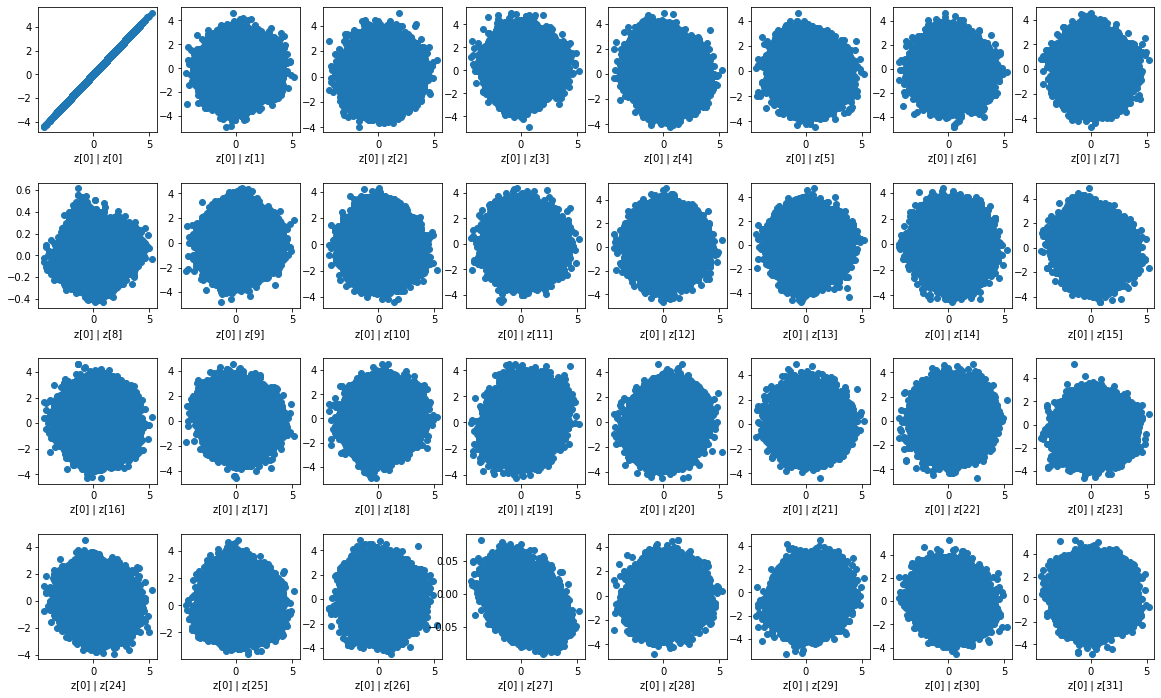

In [ ]:
plot_label_clusters(model, z_mean, data_tokens['genre'], 0)

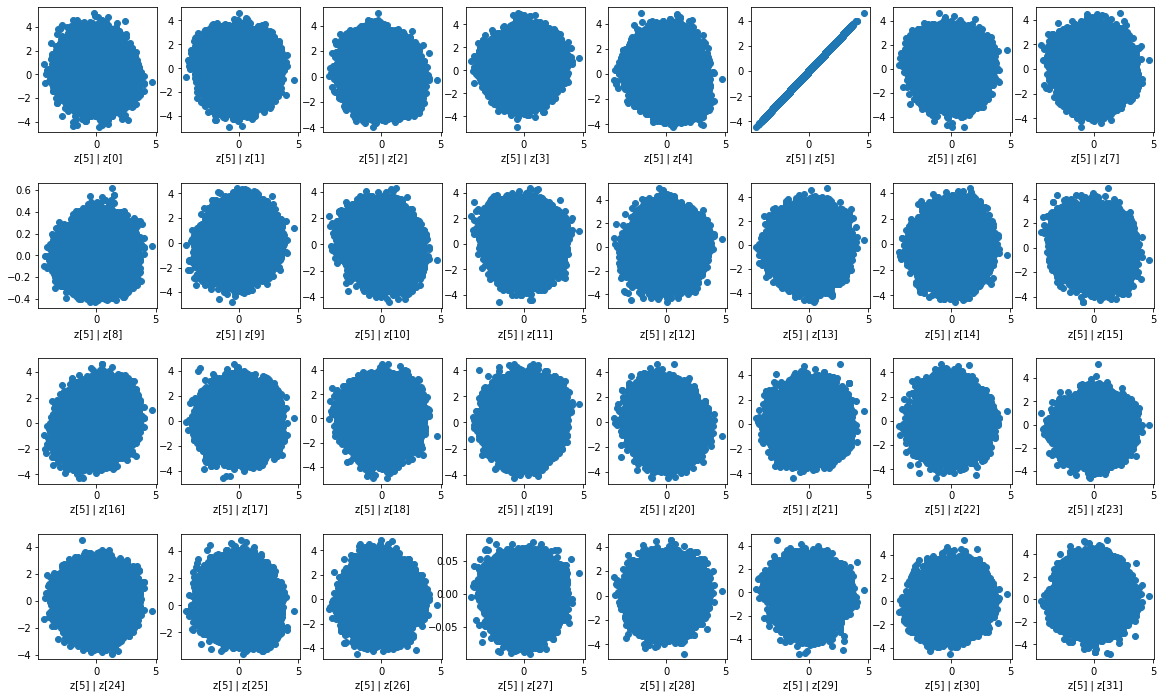

In [ ]:
plot_label_clusters(model, z_mean, None, 5)

Visualización de como cambia el factor de loss en kl para los parametros y cantidad de epochs